# Connect crashes with libraries

of the sampled crashes

## Analysis

In [1]:
import pandas as pd
import utils.config as config
import numpy as np

df_mlerr_labels = pd.read_excel(config.path_default.joinpath('Manual_labeing/libraries/df_err_processed_pregroup_sampled4_resampled7.xlsx'),
                                sheet_name = "Del-All(resampled-libs_cause)",
                                keep_default_na=False)

path_default=WindowsPath('C:/Users/yirwa29/Downloads/data_jupyter_nbs_empirical')


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [2]:
df_mlerr_labels_mllibs = df_mlerr_labels[(df_mlerr_labels["Libs-cause"]!="None")&(df_mlerr_labels["label_if_ML_bug"].isin(config.label_if_ML_bug["ML bug"]))]
print("The percentage of crashes caused by using ML libraries: ", df_mlerr_labels_mllibs.shape[0]/df_mlerr_labels.shape[0])
print("Top libraries that lead to crashes:")
pd.DataFrame(df_mlerr_labels_mllibs["Libs-cause"].value_counts()[:10]/df_mlerr_labels_mllibs.shape[0])

The percentage of crashes caused by using ML libraries:  0.42761394101876676
Top libraries that lead to crashes:


,count
Libs-cause,
pandas,0.210031
sklearn,0.156740
torch,0.115987
numpy,0.103448
keras,0.097179
tensorflow,0.084639
matplotlib,0.053292
seaborn,0.040752
cv2,0.018809


In [3]:
df_mlerr_labels_gh = df_mlerr_labels[(df_mlerr_labels["nb_source"]==config.NB_SOURCE["github"])]
df_mlerr_labels_mllibs_gh = df_mlerr_labels_mllibs[(df_mlerr_labels_mllibs["nb_source"]==config.NB_SOURCE["github"])]
print("The percentage of GH crashes caused by using ML libraries: ", df_mlerr_labels_mllibs_gh.shape[0]/df_mlerr_labels_gh.shape[0])
print("Top libraries that lead to crashes for GH notebooks:")
pd.DataFrame(df_mlerr_labels_mllibs_gh["Libs-cause"].value_counts()[:10]/df_mlerr_labels_mllibs_gh.shape[0])

The percentage of GH crashes caused by using ML libraries:  0.38974358974358975
Top libraries that lead to crashes for GH notebooks:


,count
Libs-cause,
pandas,0.210526
sklearn,0.138158
numpy,0.138158
torch,0.125000
tensorflow,0.118421
matplotlib,0.065789
seaborn,0.046053
keras,0.039474
cv2,0.026316


In [4]:
df_mlerr_labels_k = df_mlerr_labels[(df_mlerr_labels["nb_source"]==config.NB_SOURCE["kaggle"])]
df_mlerr_labels_mllibs_k = df_mlerr_labels_mllibs[(df_mlerr_labels_mllibs["nb_source"]==config.NB_SOURCE["kaggle"])]
print("The percentage of Kaggle crashes caused by using ML libraries: ", df_mlerr_labels_mllibs_k.shape[0]/df_mlerr_labels_k.shape[0])
print("Top libraries that lead to crashes for Kaggle notebooks:")
pd.DataFrame(df_mlerr_labels_mllibs_k["Libs-cause"].value_counts()[:10]/df_mlerr_labels_mllibs_k.shape[0])

The percentage of Kaggle crashes caused by using ML libraries:  0.4691011235955056
Top libraries that lead to crashes for Kaggle notebooks:


,count
Libs-cause,
pandas,0.209581
sklearn,0.173653
keras,0.149701
torch,0.107784
numpy,0.071856
tensorflow,0.053892
matplotlib,0.041916
seaborn,0.035928
statsmodels,0.017964


In [5]:
# Plot together with library usage frequency, ML API misuse, other root causes
df_mllibs_frequency = pd.read_excel(config.path_default.joinpath('Kaggle/ml_library/nb_imports_popular_libs_manual_labeled.xlsx'),
                                    sheet_name = "Yiran", keep_default_na=False)
df_mllibs_frequency = df_mllibs_frequency[df_mllibs_frequency.imports.isin(config.top_lib_names)][["imports","count"]].reindex()
df_mllibs_frequency["count"] = df_mllibs_frequency["count"].astype(int)
df_mllibs_frequency["frequency"] = df_mllibs_frequency["count"]/sum(df_mllibs_frequency["count"])

In [6]:
df_mllibs_cause = pd.DataFrame(df_mlerr_labels_mllibs_gh["Libs-cause"].value_counts())
df_mllibs_cause = df_mllibs_cause[df_mllibs_cause.index.isin(config.top_lib_names)]

In [7]:
df_mllibs_frequency = df_mllibs_frequency[df_mllibs_frequency.imports.isin(df_mllibs_cause.index)]
df_mllibs_cause = df_mllibs_cause.reindex(df_mllibs_frequency.imports)
df_mllibs_cause["Crash percentage"] = df_mllibs_cause["count"]/sum(df_mllibs_cause["count"])
df_mllibs_cause["Usage frequency"] = df_mllibs_frequency["frequency"].values

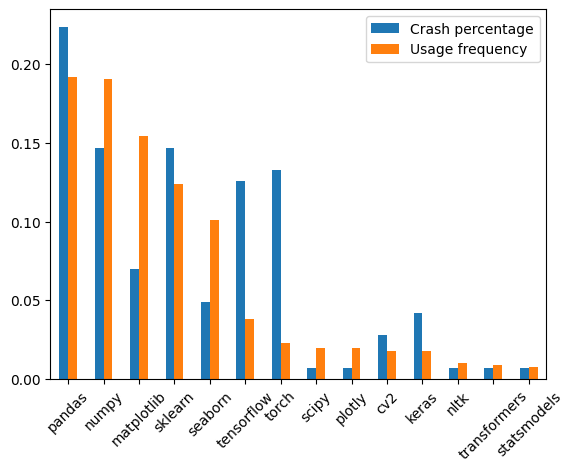

In [8]:
import matplotlib.pyplot as plt

ax = df_mllibs_cause.plot(y=["Crash percentage", "Usage frequency"], kind="bar", rot=45)
ax.set_xlabel('')
plt.show()